## Advanced Reconstruction Using BART
   
**Presenters**:

    Part 1) Nick Scholand: nick.scholand@med.uni-goettingen.de
    Part 2) Xiaoqing Wang: xiaoqing.wang@med.uni-goettingen.de
   
This notebook shows how to do advanced reconstruction using BART. We assume that you are already familiar with basic concepts of the BART command-line interface and know the basic commands.



First, we define two helper functions for visualization of images:

In [1]:
# BASH function to write BART file to png,
# display the png, and remove it afterwards
function imshow () {
    bart toimg -W $1 $1.png > /dev/null
    cat $1.png | display
    rm $1.png
}
export -f imshow

# version without automatic windowing
function imshow_nowin () {
    bart toimg $1 $1.png > /dev/null
    cat $1.png | display
    rm $1.png
}
export -f imshow_nowin

### Example 1: Cartesian Parallel Imaging Compressed Sensing

We start with a simple example that already demonstrates a couple of useful functions in BART: 

* Creation of synthetic k-space data using the `phantom` tool
* Creation of Poisson-disc undersampling patterns using the `poisson` tool
* Calibration of sensitivities using ESPIRIT using the `ecalib` tool
* Parallel imaging and compressed sensing using `pics` tool

On the first step, we will create synthetic multi-coil k-space data using the `phantom` tool. We use the '-k' option to specify that we want to simulate **k-space** data, the `-x` option to set the **matrix size** and `-s` to set the number of **coils**.

In [2]:
SIZE=256
COILS=8

# Create fully-sampled Cartesian phantom
bart phantom -x$SIZE -s$COILS -k shepp

We then reshape the k-space data and display it.

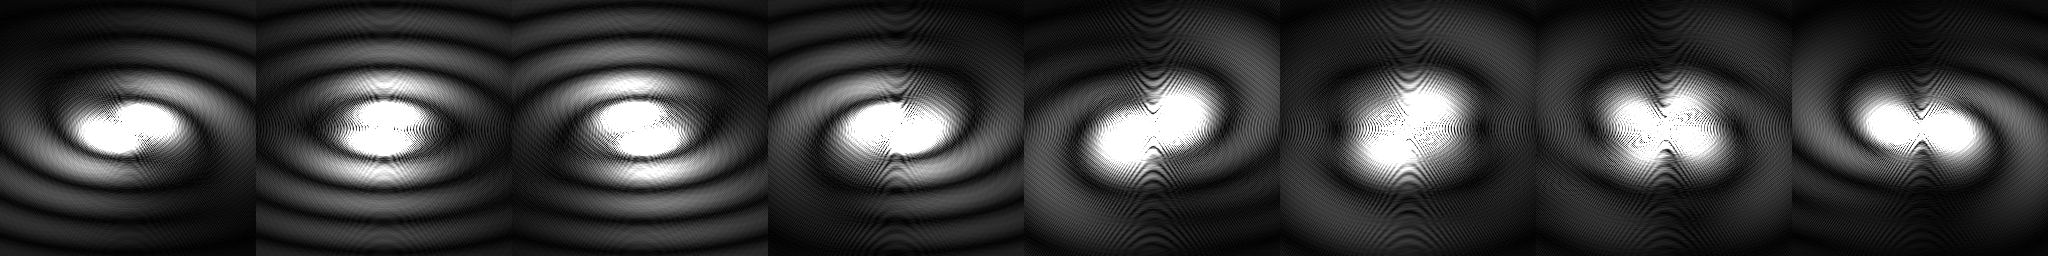

Figure: multi-channel k-space phantom


In [3]:
# Reshape the data for displaying. Concatenate the row dimension 1 with the coil dimension 3.
bart reshape $(bart bitmask 1 3) $((SIZE * COILS)) 1 shepp shepp_flat

# Display k-space phantom
imshow shepp_flat
echo "Figure: multi-channel k-space phantom"

Next, we create an undersampling pattern. To demonstrate compressed sensing, we choose a **Poisson-disc undersampling pattern** with 2x2 in-plane acceleration (`-y`,`-z`) for a given matrix size (`-Y`,`-Z`). We also set the auto-calibration region `-C` to 32x32 samples and specify an elliptical scanning scheme `-e`.

points: 13591, grid size: 256x256x(pi/4) = 51471 (R = 3.787201)


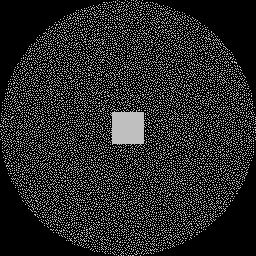

Figure: Poisson-disc sampling pattern


In [4]:
# Create Poisson-disc undersampling pattern
INPLANE_ACC=2
AUTO_CAL=32

# 2x2-fold in-plane acceleration. Auto-calibration region: 32x32
bart poisson -Y $SIZE -y $INPLANE_ACC -Z $SIZE -z $INPLANE_ACC -C $AUTO_CAL -e tmp_poisson

# As poisson uses y and z dimensions while phantom uses x and y, use squeeze to remove first empty dimension
bart squeeze tmp_poisson poisson

# Display the result
imshow poisson
echo "Figure: Poisson-disc sampling pattern"

We now create an undersampled k-space by applying the pattern to the fully-sampled k-space using `fmac`.

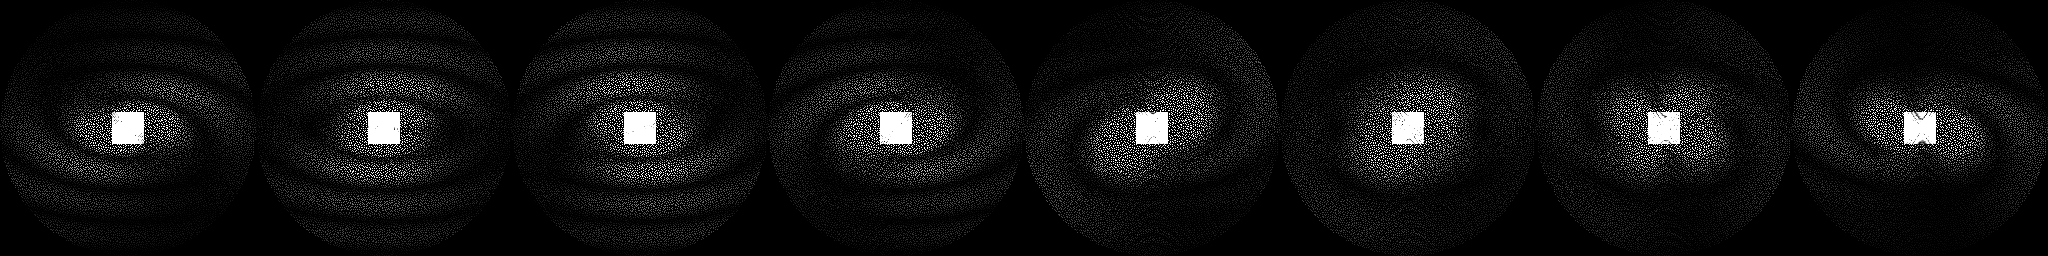

Figure: under-sampled k-space


In [5]:
# Multiply pattern and k-space to obtain undersampled k-space
bart fmac shepp poisson shepp_usamp

# Show undersampled k-space phantom
bart reshape $(bart bitmask 1 3) $((SIZE * COILS)) 1 shepp_usamp shepp_usamp_flat

imshow shepp_usamp_flat
echo "Figure: under-sampled k-space"

Note that the undersampling pattern was automatically applied to each coil.

After creating the under-sample data, we now first perform a simple reconstruction using an inverse Fourier transform (`fft`) and root-sum-of-squares coil combination (`rss`).

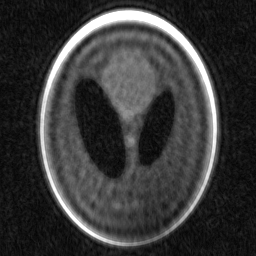

Figure: RSS Reconstruction


In [6]:
# Simple FFT reconstruction

# Perform inverse FFT reconstruction
bart fft -i -u $(bart bitmask 0 1) shepp_usamp shepp_fft

# Combine coils by root-sum-of-squares
bart rss $(bart bitmask 3) shepp_fft shepp_fft_rss

# Show FFT reconstruction
imshow shepp_fft_rss
echo "Figure: RSS Reconstruction"

The result is - of course - not very pleasing. The image is corrupted by ringing and noise-like artifacts.

Let's try a more advanced reconstruction technique. We therefore need to determine the coil sensitivities. Here, we use the ESPIRiT to obtain the sensitivity for each coil. We will now have a closer look at the ESPIRiT `ecalib` tool.

In [7]:
bart ecalib -h

Usage: ecalib [-t f] [-c f] [-k ...] [-r ...] [-m d] [-S] [-W] [-I] [-1] [-P] [-v f] [-a] [-d d] <kspace> <sensitivites> [<ev-maps>]

Estimate coil sensitivities using ESPIRiT calibration.
Optionally outputs the eigenvalue maps.

-t threshold      	This determined the size of the null-space.
-c crop_value      	Crop the sensitivities if the eigenvalue is smaller than {crop_value}.
-k ksize      	kernel size
-r cal_size      	Limits the size of the calibration region.
-m maps      	Number of maps to compute.
-S		create maps with smooth transitions (Soft-SENSE).
-W		soft-weighting of the singular vectors.
-I		intensity correction
-1		perform only first part of the calibration
-P		Do not rotate the phase with respect to the first principal component
-v variance      	Variance of noise in data.
-a		Automatically pick thresholds.
-d level      	Debug level
-h		help


The default number of maps is 2. For simplicity we will only use one set of coil sensitivities in this example by using the option `-m1`.

Done.


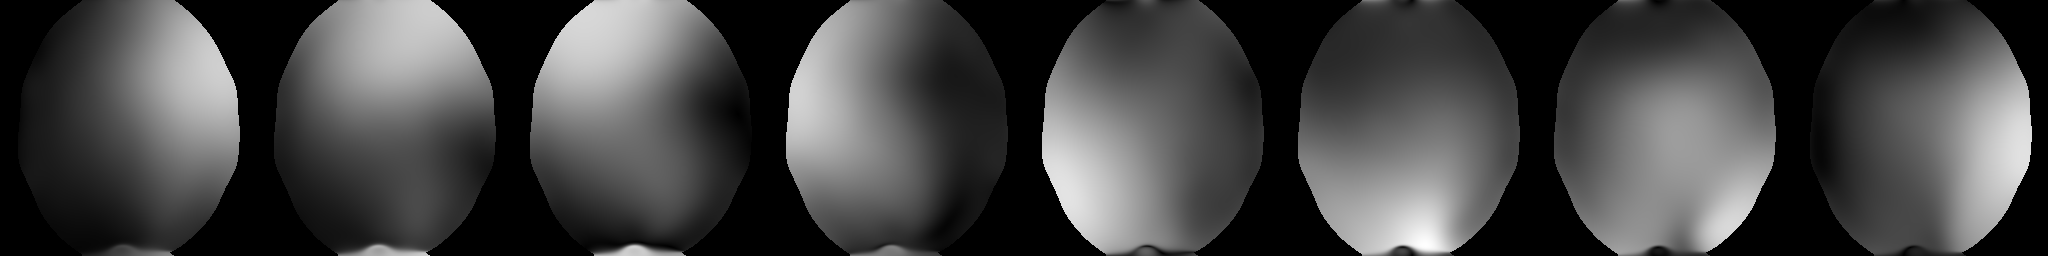

Figure: Sensitivity maps estimated with ESPIRiT


In [8]:
# Compute sensitivity maps using ESPIRiT
bart ecalib -m1 shepp_usamp sens

# Show sensitivity maps of the espirit maps
bart reshape $(bart bitmask 1 3) $((SIZE * COILS)) 1 sens sens_flat

imshow_nowin sens_flat
echo "Figure: Sensitivity maps estimated with ESPIRiT"

Given the sensitivities, the **`pics`** command can be used to perform an iterative parallel-imaging reconstruction using various regularization terms. It solves the following minimization problem:

$${argmin} \,_x \quad  \| P F S x - y \|_2^2 + \lambda R(x) $$
- $F$ is the Fourier transform
- $P$ is the sampling operator
- $S$ is the multiplication with the sensitivities
- $x$ is the unnown image
- $y$ is the acquired kspace data
- $R$ is the regularization term
- $\lambda$ is the regularization parameter

A popular regularization is $\ell_2$ regularization with 
$$R(x) = \| x \|_2^2.$$
The reconstruction then corresponds to a SENSE reconstruction.

Size: 65536 Samples: 13591 Acc: 4.82
l2 regularization: 0.005000
conjugate gradients
Total Time: 1.079136


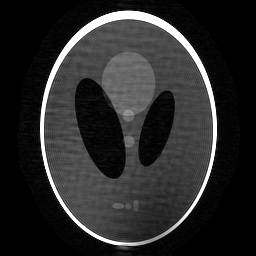

Figure: Iterative SENSE Reconstruction


In [9]:
LAMBDA=0.005
ITER=50

# Parallel-imaging reconstruction using L2 regularization
bart pics -S -l2 -r$LAMBDA -i $ITER shepp_usamp sens shepp_l2

# Show L2-regularized reconstruction
imshow shepp_l2
echo "Figure: Iterative SENSE Reconstruction"

The result is definitely better than the FFT reconstruction, but undersampling artifacts are still visible.<br><br>
We therefore try another regularization term: $\ell_1$-Wavelet
 $$ R(x) = \| \Psi x \|_1$$
which theoretically is more ideal for the noise-like artifacts of the Poisson-disc undersampling.

Size: 65536 Samples: 13591 Acc: 4.82
l1-wavelet regularization: 0.007500
FISTA
Total Time: 1.710415


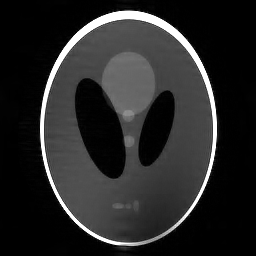

Figure: L1-wavelet Regularization


In [10]:
LAMBDA=0.0075
ITER=100

# Parallel-imaging compressed-sensing reconstruction using L1-wavelet regularization
bart pics -S -R W:$(bart bitmask 0 1):0:$LAMBDA -i $ITER shepp_usamp sens shepp_wavelet

# Show L1-wavelet reconstructions
imshow shepp_wavelet
echo "Figure: L1-wavelet Regularization"

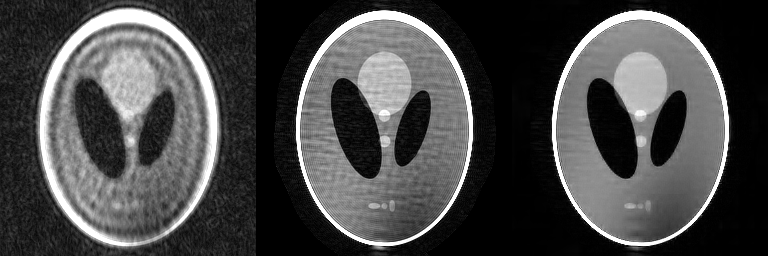

Figure: Zerofill Reco             SENSE (L2)Reco               Compressed Sensing (L1)


In [11]:
# Combine all reconstructed images for visualization
bart join 1 shepp_fft_rss shepp_l2 shepp_wavelet shepp_comb

imshow shepp_comb
echo "Figure: Zerofill Reco             SENSE (L2)Reco               Compressed Sensing (L1)"

#### Short Summary:

The Cartesian compressed-sensing parallel-imaging example demonstrates the effect of exploiting the sensitivity profiles of the receive coils using parallel imaging and additional constraining the solution  with prior knowledge through regularization. The noise-like artefacts are less dominant in SENSE compared to the FFT reconstruction, but then are
almost completely removed when also using compressed sensing.

### Example 2: Reconstruction of Non-Cartesian Data

#### Creating a Test Dataset
To simulate a radial dataset, have a look into the help of the `phantom` tool.

In [12]:
bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <string>] [-G ...] [-T ...] [-B ...] [-x d] [-g d] [-3] [-b] <output>

Image and k-space domain phantoms.

-s nc      	nc sensitivities
-S nc      	Output nc sensitivities
-k		k-space
-t file      	trajectory
-G		geometric object phantom
-T		tubes phantom
-B		BART logo
-x n      	dimensions in y and z
-g n=1,2      	select geometry for object phantom
-3		3D
-b		create basis for geometry
-h		help


We see that there is an option to pass-in a trajectory file: `-t file`. This allows us to create phantom data for **arbitrary k-space trajectories** specified by the `.cfl-file`.

In the following we will have a look on how the trajectory file needs to be structured. Therefore, let us create one with the trajectory tool in BART: `traj`

In [13]:
bart traj -h

Usage: traj [-x d] [-y d] [-a d] [-t d] [-m d] [-l] [-g] [-r] [-G] [-H] [-s d] [-D] [-R f] [-q ...] [-Q ...] [-O] [-3] [-c] [-z ...] [-C <string>] <output>

Computes k-space trajectories.

-x x      	readout samples
-y y      	phase encoding lines
-a a      	acceleration
-t t      	turns
-m mb      	SMS multiband factor
-l		aligned partition angle
-g		golden angle in partition direction
-r		radial
-G		golden-ratio sampling
-H		halfCircle golden-ratio sampling
-s # Tiny GA      	tiny golden angle
-D		projection angle in [0,360°), else in [0,180°)
-R phi      	rotate
-q delays      	gradient delays: x, y, xy
-Q delays      	(gradient delays: z, xz, yz)
-O		correct transverse gradient error for radial tajectories
-3		3D
-c		asymmetric trajectory [DC sampled]
-z Ref:Acel      	Undersampling in z-direction.
-C file      	custom_angle file [phi + i * psi]
-h		help


To create radial trajectories, the required command-line flag is `-r`.

Let us create a radial trajectory with (2x) 256 readout samples and 128 radial spokes. We rescale our trajectory by a factor of 0.5 for oversampling by a factor of two. The real measurement data used later in this tutorial is also oversampled by a factor of two.

In [14]:
SAMPLES=512
SPOKES=128

bart traj -x$SAMPLES -y$SPOKES -r tmp_traj

# Rescale trajectory
bart scale 0.5 tmp_traj traj

Have a look into the dimensions of a trajectoy file by printing the header file (`.hdr`).

In [15]:
bart show -m traj

Type: complex float
Dimensions: 16
AoD:	3	512	128	1	1	1	1	1	1	1	1	1	1	1	1	1


It is a 3D array. The dimension in position 0 with length 3 corresponds the three coordinates x, y and z. Thus, the trajectory file includes the **coordinates** (dim 0) in (x,y,z) for every **sample** (dim 1) on every **spoke** (dim 2).

The radial phantom dataset can be computed by passing the trajectory to the `phantom` tool.

In [16]:
bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <string>] [-G ...] [-T ...] [-B ...] [-x d] [-g d] [-3] [-b] <output>

Image and k-space domain phantoms.

-s nc      	nc sensitivities
-S nc      	Output nc sensitivities
-k		k-space
-t file      	trajectory
-G		geometric object phantom
-T		tubes phantom
-B		BART logo
-x n      	dimensions in y and z
-g n=1,2      	select geometry for object phantom
-3		3D
-b		create basis for geometry
-h		help


In our example we only need the `-k` flag for getting kspace data and `-t` to specify the trajectory. 

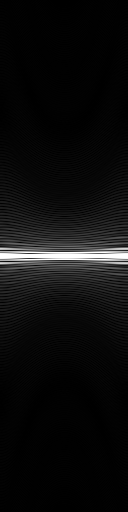

Figure: non-Cartesian k-space data for the Shepp-Logan phantom

Dimensions of the data:

Type: complex float
Dimensions: 16
AoD:	1	512	128	1	1	1	1	1	1	1	1	1	1	1	1	1


In [17]:
# Create a phantom data set based on the previously created trajectory
bart phantom -k -t traj data

imshow data
echo "Figure: non-Cartesian k-space data for the Shepp-Logan phantom"
echo 

echo "Dimensions of the data:"
echo
bart show -m data

Here we visualized the radial spokes with the kspace center recognizable as bright central line.

#### Reconstruction of Non-Cartesian Datasets

After we created the radial dataset, we now proceed with reconstructing it. Luckily, BART includes an implementation of a non-uniform FFT: `nufft`.

In [18]:
bart nufft -h

Usage: nufft [-a] [-i] [-d ...] [-t] [-r] [-c] [-l f] [-P] [-s] [-g] [-1] <traj> <input> <output>

Perform non-uniform Fast Fourier Transform.

-a		adjoint
-i		inverse
-d x:y:z      	dimensions
-t		Toeplitz embedding for inverse NUFFT
-r		turn-off Toeplitz embedding for inverse NUFFT
-c		Preconditioning for inverse NUFFT
-l lambda      	l2 regularization
-P		periodic k-space
-s		DFT
-g		GPU (only inverse)
-1		use/return oversampled grid
-h		help


We are going to have a closer look into the adjoint `-a` and the inverse `-i`.

Let us start with the adjoint.

Est. image size: 256 256 1
Done.


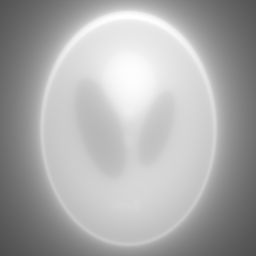

Figure: Adjoint nuFFT Reconstruction


In [19]:
# Use the nufft tool to reconstruct the data
bart nufft -a traj data reco_a

imshow_nowin reco_a
echo "Figure: Adjoint nuFFT Reconstruction"

As the adjoint of the nuFFT does not compensate for the higher sampling density in the k-space center, the result is blurred. This could be fixed by using a Ram-Lak filter, but we will focus on iterative reconstruction in this tutorial.

Now let us see how the inverse `-i` performs.

Est. image size: 256 256 1
Done.


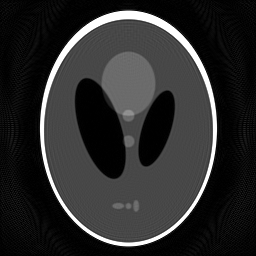

Figure: Inverse nuFFT Reconstruction


In [20]:
# Use the nufft tool to reconstruct the data
bart nufft -i traj data reco

imshow reco
echo "Figure: Inverse nuFFT Reconstruction"

This reconstruction is much better, because the inverse compensates for density differences in k-space.

### Example 3: Coil Sensitivity Estimation from Non-Cartesian Data

We already saw an application of ESPIRiT to estimate sensitivities from Cartesian Poisson-disc undersampled data. 
This chapter shows how to estimate sensitivities from non-Cartesian data. We first show how ESPIRiT can be used to estimate sensitivities for non-Cartesian data and then also show an alternative technique using the nonlinear inverse (NLINV) method.

Radial sampling trajectories are intrinsically oversampled in the central k-space area.  We now create a radial trajectory the same way we have already seen, but then add the `-s` flag to simulate the phantom data for eight coils.

In [21]:
SAMPLES=512
#SAMPLES=256
SPOKES=48
COILS=8

# Create radial trajectory
bart traj -x$SAMPLES -y$SPOKES -r tmp_traj

# Rescale trajectory to avoid infolding artifacts
bart scale 0.5 tmp_traj traj

# Create radial dataset
bart phantom -k -s$COILS -t traj data

echo "Radial Dataset:"
echo
bart show -m data

Radial Dataset:

Type: complex float
Dimensions: 16
AoD:	1	512	48	8	1	1	1	1	1	1	1	1	1	1	1	1


#### Coil-Profile Estimation with ESPIRiT

ESPIRiT requires Cartesian data. For non-Cartesian data, we first reconstruct coil images using `nufft`, then convert them into Cartesian multi-coil k-space using `fft`, and then apply `ecalib` to estimate the sensitivities.

Est. image size: 256 256 1
Done.
Done.


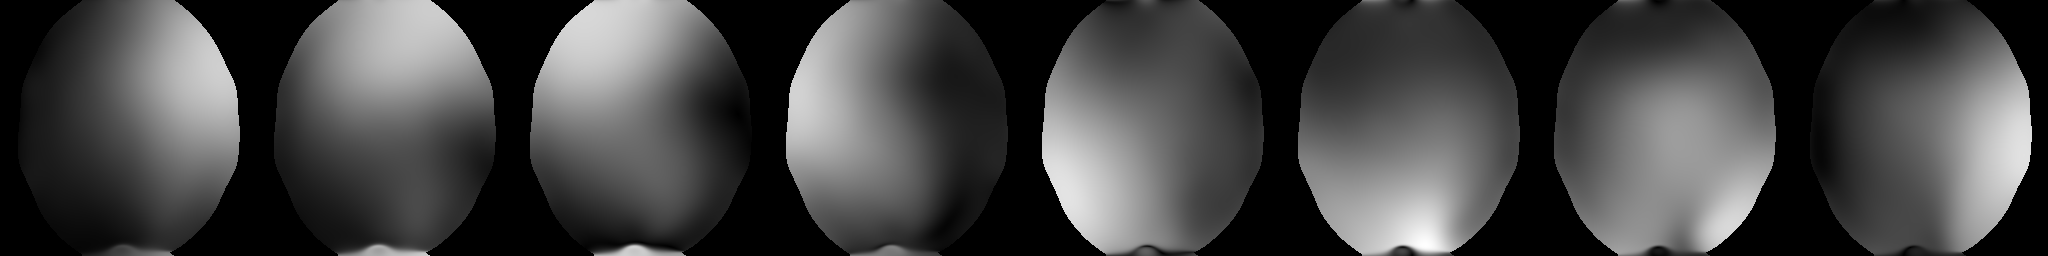

Figure: Sensitivites estimates using ESPIRiT


In [22]:
# Apply inverse nufft to reconstruct all eight coil images
bart nufft -i -t traj data coil_img

# Use DFT to compute Cartesian k-space
bart fft -u $(bart bitmask 0 1) coil_img ksp

# Compute sensitivities using ESPIRiT
bart ecalib -m1 ksp sens

# Reshape and display sensitivities
bart reshape $(bart bitmask 1 3) $((SAMPLES / 2 * COILS)) 1 sens sens_reshape

imshow_nowin sens_reshape
echo "Figure: Sensitivites estimates using ESPIRiT"

#### Coil-Profile Estimation with Non-Linear Inversion 

Note: this requires a recent BART version.

We will now estimate the coil profiles from non-Cartesian data by using the nonlinear inverse reconstruction (NLINV).

By treating the reconstruction as a single inverse problem, the image as well as the coils are estimated jointly from the non-Cartesian data. NLINV will compute the sensitivities on a two-fold increased FOV which avoids problems at the boundary.

nufft kernel dims: [  1 512  48   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [512 512   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 512  48   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 24576 (vs. 286720) + 262144
ksp : [  1 512  48   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [512 512   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512  48   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512  48   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [512 512   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512  48   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 0.000122
Step: 0, Res: 100.000000
	 cg:   0
Step: 1, Res: 1673.972094
	 cg:   0
Step: 2, Res: 105.739328
	 cg:   2
Step: 3, Res: 90.735683
	 cg:   2
Step: 4, Res: 70.140348
	 cg:   3
Step: 5, Res: 34.707677
	 cg:   6
Step: 6, Res: 1

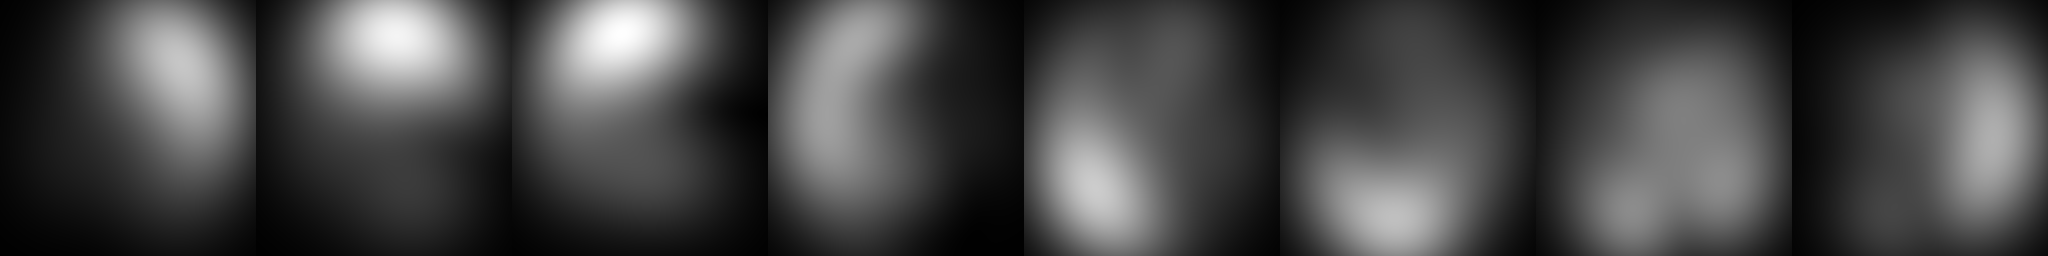

Figure: Sensitivities estimated using NLINV


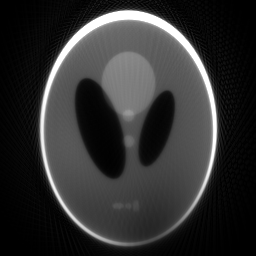

Figure: Image reconstructed using NLINV


In [23]:
ITER=8
DEBUG=4

# Start NLINV reconstruction
bart nlinv -d$DEBUG -i$ITER -a1000 -t traj data reco sens_nlinv

# Extract central part
bart resize -c 0 $(($SAMPLES / 2)) 1 $(($SAMPLES / 2)) sens_nlinv sens

# Reshape for visualization
bart reshape $(bart bitmask 1 3) $(($SAMPLES / 2 * $COILS)) 1 sens sens_nlinv_flat

imshow_nowin sens_nlinv_flat
echo "Figure: Sensitivities estimated using NLINV"

imshow reco
echo "Figure: Image reconstructed using NLINV"

### Example 4: Compressed-Sensing Parallel Imaging Reconstruction for Radial Data

In this part, we will introduce how to perform the compressed-sensing reconstruction for multi-coil radial data using the  `pics` tool.

The `pics` tool allows us to do the parallel-imaging reconstructions with various regularizations. It basically solves the following minimization problem:

$$\operatorname{argmin} \,_x \quad \| P F S x - y \|_2^2 + \lambda R(x) $$
- ${F}$ is the Fourier transform
- ${P}$ is the sampling operator
- $S$ is the multiplication with the sensitivities
- $x$ is the unknown image
- $y$ is the acquired kspace data
- $R$ is the regularization term
- $\lambda$ is the regularization parameter


The regularization term could be a $\ell_2$ regularization with

$$R(x) = \| x \|_2^2$$

or a $\ell_{1}$-Wavelet regularization (compressed sensing)

$$ R(x) = \| \Psi x \|_1$$.


There are also many other options. All supported regularization techniques can be found using the help `-Rh`.

In [24]:
bart pics -Rh

Generalized regularization options (experimental)

-R <T>:A:B:C	<T> is regularization type (single letter),
		A is transform flags, B is joint threshold flags,
		and C is regularization value. Specify any number
		of regularization terms.

-R Q:C    	l2-norm in image domain
-R I:B:C  	l1-norm in image domain
-R W:A:B:C	l1-wavelet
-R N:A:B:C	Normalized Iterative Hard Thresholding (NIHT), image domain
		C is an integer percentage, i.e. from 0-100
-R H:A:B:C	NIHT, wavelet domain
-R F:A:B:C	l1-Fourier
-R T:A:B:C	total variation
-R T:7:0:.01	3D isotropic total variation with 0.01 regularization.
-R L:7:7:.02	Locally low rank with spatial decimation and 0.02 regularization.
-R M:7:7:.03	Multi-scale low rank with spatial decimation and 0.03 regularization.


Let's do the reconstructions for the previously simulated radial data with eight channels. First, we do the reconstruction with the $\ell_2$ regularization.

[  1 512  48   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
l2 regularization: 0.000100
conjugate gradients
Total Time: 1.417374


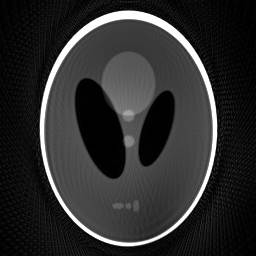

Figure: l2 Reconstruction


In [25]:
LAMBDA=0.0001 # regularization strength

# Perform an iterative SENSE reconstruction
bart pics -R Q:$LAMBDA -t traj data sens reco_l2

# -t - k-space trajectory
# sens_nlinv_center- coil sensitivity profiles

imshow reco_l2
echo "Figure: l2 Reconstruction"

Then, we perform the reconstruction with the $\ell_{1}$-Wavelet regularization.

[  1 512  48   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
Maximum eigenvalue: 4.39e-01
l1-wavelet regularization: 0.001500
FISTA
Total Time: 5.450122


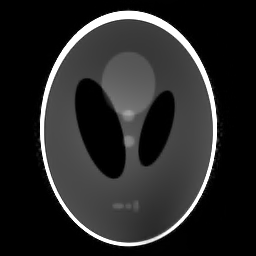

Figure: l1-Wavelet Reconstruction


In [26]:
LAMBDA=0.0015 # regularization strength
ITER=100

# Perform the compressed-sensing reconstruction, 
# "bitmask" specifies the dimensions where we want to apply the regularization.
# Here we want to apply the l1-Wavelet regularization to the spatial dimensions,
# i.e., dimensions 0 and 1.
bart pics -R W:$(bart bitmask 0 1):0:$LAMBDA -e -i$ITER -S -t traj data sens reco_l1

# -e - scale stepsize based on max. eigenvalue (FISTA)
# -i - max. number of iterations

imshow reco_l1
echo "Figure: l1-Wavelet Reconstruction"

### Short Summary: 

In these examples, we showed how to estimate sensitivities from radial data using ESPIRiT and  NLINV and how to perform non-Cartesian parallel-imaging compressed-sensing reconstruction using the  `pics` tool. While the radial sampling is tolerant to undersampling, the additional $\ell_{1}$-wavelet spatial regularization can help to reduce steaking artifacts further.

### Example 5: GRASP- Compressed-Sensing Reconstruction

Instead of reconstructing a single image, one can jointly reconstruct an image series at once, exploiting sparsity in the  time dimension. A popular choice is to use **total variation (TV) regularization** along the **time dimension**. This is  useful for reconstructing images with similar spatial structures but with different contrasts. In the GRASP technique, this is combined with Golgen-ratio radial sampling.

 $$ \operatorname{argmin} \,_{x} \quad \|P F Sx - y\|_{2}^{2} + \lambda R(x), \quad \text{with} \quad R(x) = \| TV (x) \|_1$$
 


In [27]:
# the view tool is not supported in this binder repository
# download it and execute in on your local machine to use this function
#view data/img

In [28]:
# load the raw data (continuous golden-ratio radial acquisition)
# This is an in-vivo liver dataset (courtesy of Tobias Block, NYU)
# with 2-fold oversampling of readout and a continous golden-angle radial acquisition.
KSPACE=data/slice

# print out dimensions of the dataset
bart show -m $KSPACE

Type: complex float
Dimensions: 16
AoD:	512	2100	1	6	1	1	1	1	1	1	1	1	1	1	1	1


To perform reconstruction, we first need to create the trajectory. Again, we use the `traj` tool from BART.

In [29]:
# create Golden-ratio radial trajectory
READ=$(bart show -d0 $KSPACE)
ALLSPOKES=$(bart show -d1 $KSPACE)

# create the actual trajectory the dataset was acquired with
bart traj -G -x$READ -y$ALLSPOKES tmp1


# print out dimensions
bart show -m tmp1

Type: complex float
Dimensions: 16
AoD:	3	512	2100	1	1	1	1	1	1	1	1	1	1	1	1	1


Now, let us preprocess our data.

In [30]:
# oversampling

SCALE=0.6
bart scale $SCALE tmp1 tmp2

In [31]:
# group the trajectory into 100 phases with 21 spokes each
SPOKES=21
PHASES=100

# split off time/phase dimension into index 10
bart reshape $(bart bitmask 2 10) $SPOKES $PHASES tmp2 traj

# print out dimensions
bart show -m traj

Type: complex float
Dimensions: 16
AoD:	3	512	21	1	1	1	1	1	1	1	100	1	1	1	1	1


In [32]:
# group the data into 100 phases with 21 spokes each

# split-off time/phase dim
bart reshape $(bart bitmask 1 2) $SPOKES $PHASES $KSPACE tmp1

# move time/phase dimensions to dim 10 and reshape
bart transpose 2 10 tmp1 tmp2 
bart reshape $(bart bitmask 0 1 2) 1 $READ $SPOKES tmp2 kspace

# print out dimensions
bart show -m kspace

Type: complex float
Dimensions: 16
AoD:	1	512	21	6	1	1	1	1	1	1	100	1	1	1	1	1


After preparation of the data, we can start the reconstruction. With the `-RT:A:B:C` option, we can choose the total-variation regularization term for the reconstruction. The regularization will be applied to the 10th dimension as specified by the bitmask.

In [33]:
LAMBDA=0.01    # Regularization strength
LAGRANGIAN=10. # Lagrangian parameter for ADMM
ITER=50        # Number of iterations

# load a pre-calculated coil sensitivity profiles
SENS=data/sens

bart pics -R T:$(bart bitmask 10):0:$LAMBDA -u$LAGRANGIAN -i$ITER -t traj kspace $SENS data/img

# reconstruction with l2 regularization
# bart pics -R Q:$LAMBDA -u$LAGRANGIAN -i$ITER -S -t traj kspace $SENS data/img_l2

[  1 512  21   6   1   1   1   1   1   1 100   1   1   1   1   1 ]
[308 308   1   6   1   1   1   1   1   1 100   1   1   1   1   1 ]
TV regularization: 0.010000
ADMM
Total Time: 174.580674


Because this reconstruction takes around 3 min on my local machines (with server/gpu should be much faster!), we only show results we have reconstructed previously.

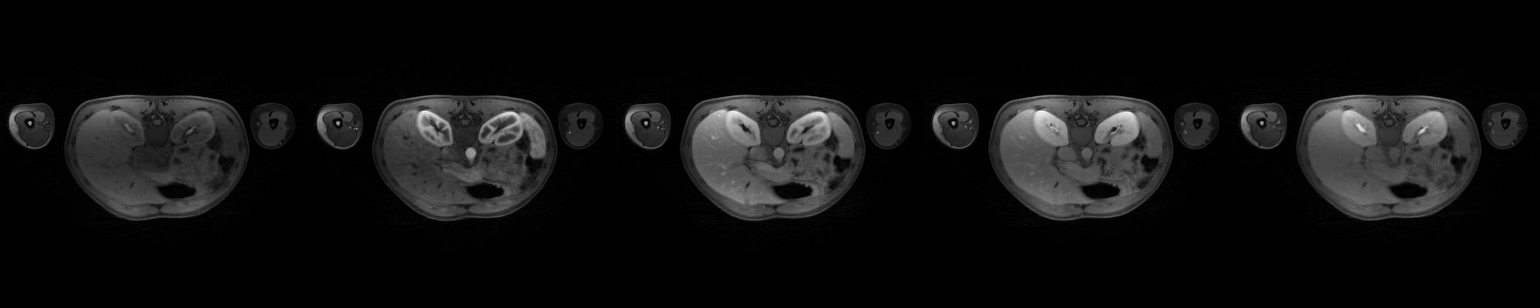

Figure: Selected Images of a GRASP reconstruction


In [34]:
# extract 5 example images from the image series and combine them into one single figure for display
bart slice 10 0 data/img img_00
bart slice 10 10 data/img img_01
bart slice 10 25 data/img img_02
bart slice 10 49 data/img img_03
bart slice 10 99 data/img img_04

# join all images along dim 1, here we use a BASH feature to produce the file names
bart join 1 img_0{0,1,2,3,4} img_joint

imshow_nowin img_joint
echo "Figure: Selected Images of a GRASP reconstruction"

As we can see, the reconstructed images are flipped. We can use a bart command to flip the images back. Kidneys on top of our image?! Weird! So let us fix this.

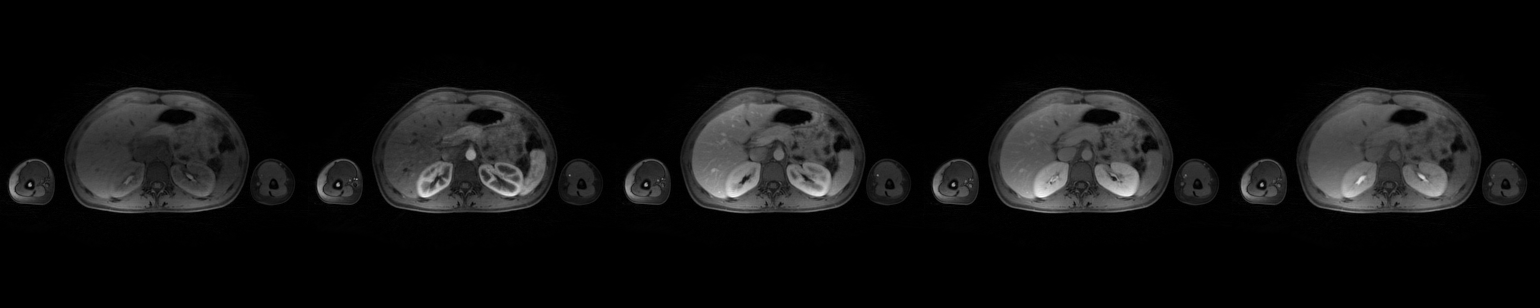

Figure: Selected Images of a GRASP reconstruction (flipped)


In [36]:
# flip the images to get a correct image orientation

bart flip $(bart bitmask 0) img_joint img_flip
imshow_nowin img_flip
echo "Figure: Selected Images of a GRASP reconstruction (flipped)"

### Short Summary: 

In this example, we showed how to do a GRASP compressed-sensing parallel-imaging reconsructions using the BART `pics` tool. GRASP can reconstruct images with high quality for an undersampling factor of around 19 ($\approx 256\cdot \frac{\pi}{2} / 21 $).

Thank you for joining our webinar! We hope you had some fun with it and learned a lot! :)